# SUBSYSTEM 1: LANDMARK EXTRACTION
### Dependencies
- Python 3.7
- Tensorflow 2

In [27]:
import tensorflow as tf
import numpy as np
# import sklearn as sk
import pandas as pd
import cv2
import os 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt             
import random
import ipywidgets as widgets
from IPython.display import display
# from ipywidgets import interact, IntSlider
import pickle
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
import time
# from utils import *
# Load the saved model
from tensorflow.keras.models import load_model
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder
print("Imported correctly ...")


Imported correctly ...


# Step 1: Create train and test datasets

In [3]:
PATH_DATASET_1 = '../dataset/Dataset_Subsystem_1.csv'
PATH_DATASET_2 = '../dataset/Dataset_Subsystem_1.csv'
PATH_VIDEOS    = '../dataset/videos'

Usefull custom functions

In [4]:
###################
# Usefull functions
###################
FRAME_WIDTH       = 640
FRAME_HEIGHT      = 480


def getFrames(path):
    '''
    Args: String.
    Returns: arr: Numpy array containing all frames in video.
    '''
    arr = []
    videocap = cv2.VideoCapture(path)

    if '723/open_palm.webm' in path:
        ret, frame = videocap.read()
        ret, frame = videocap.read()
    else:
        ret, frame = videocap.read()
    while ret:

       #!TODO: Fix landmarks positions of croped videos.
        ret, frame = videocap.read()
        if not ret:
            break

        frame = frame[:FRAME_HEIGHT, :FRAME_WIDTH, :]  # Crop videos to 480x640
        arr.append(frame)

    videocap.release()
    return np.array(arr)

# def displayFrame(frame):
#     disp = widgets.Image()
#     display_image = cv2.imencode('.png', frame)[1].tostring()
#     disp.value = display_image
#     display(disp)
    
    
def displayFrame(frame, landmarks = None):
    frame = frame.copy()
    if landmarks is not None:  
#         frame = frame.reshape(96, 96, 3)
        landmarks = landmarks.reshape(2,5,4,2) # (2 hand sides, 5 fingers, 4 landmarks, 2 coordinates)
        for side in landmarks:
            root = side[0][0]
            for finger in side:
                for lmarks in finger:
                    cv2.circle(frame, (lmarks[0], lmarks[1]), 3, color=(0,255,0))

    plt.imshow(frame)
    plt.show()


def showRandomFrame(X, Y):
    randint = random.randint(0, len(X))
    displayFrame(X[randint], Y[randint]) 


### Load raw dataset

The provided datatset has the following problems:
- open palm from 723  has a missing frame. ![Missing Frame](notebook_imgs/723_missing_frame.png)

- Videos from 723 are in wrong shape (We expexted frames of shape 480x640:  <img src="notebook_imgs/723_video_dims.png" width="300">
**The script below does the following:**
- Find all frames from all videos and it's correspondent landmarks.
- Fixes the missing frame of video '723/open_palm.webm'
- Fixes the wrong shape of videos from '723' to the shape (480,640,3)
- Fixes landmarks of videos from '723' that lays outside (480, 640).
- Creates a list of 60 numpy array containing all frames from all 60 videos. List stored in 'X'
- Creates an array of landmarks from all frames stored in 'Y'.

In [9]:
##########################################
# SUBSYSTEM I: Landmark Extraction dataset
##########################################

# Change below
LOAD_SAVED_DATA = False # Create dataset or load from saved file.

# X1 : dataset in shape (numvids * numframes, 480, 640 ,3 )
LANDMARK_OFFSET_I = 5
FRAME_WIDTH       = 640
FRAME_HEIGHT      = 480

if LOAD_SAVED_DATA:
    # Load dataset
    print("Loading datasets ...")
    X_orig = np.load('data/original_frames.npy')
    Y_orig = np.load('data/original_landmarks.npy')
    print(X_orig.shape)
    print(Y_orig.shape)
    
else:
    # Importing dataset (dtype: string and uint32)
    dset_1 = pd.read_csv(PATH_DATASET_1, sep=",", dtype={'ID': str, 'source': str, 'camera_facing_side': str, 'gesture': str})

    # Extracting landmarks
    Y1features = dset_1.columns[LANDMARK_OFFSET_I:]
    Y1         = dset_1[Y1features].to_numpy()

    # Ignore landmarks (set to 0) outside heigh 480 and width 640
    index_outside_width = [Y1[:,::2] > FRAME_WIDTH]
    Y1[:,::2][index_outside_width] = np.zeros(Y1[:,::2][index_outside_width].shape)

    index_outside_width = [Y1[:,1::2] > FRAME_HEIGHT]
    Y1[:,1::2][index_outside_width] = np.zeros(Y1[:,1::2][index_outside_width].shape)
    

    # Construct path to every video base on ID + source.
    num_samples  = dset_1["ID"].size                          # Num of samples (# videos * frames).
    paths_arr    = dset_1["source"].drop_duplicates() # Retrieve ID and source columns.
    paths_full   = [os.path.join(PATH_VIDEOS, p) for p in paths_arr.values]

    # Compute number of frames per video. (cv2.CAP_PROP_FRAME_COUNT does not work)
    idx_frames   = np.append(paths_arr.index.to_numpy(), num_samples) # Contains comulative number of frames.
    num_frames   = idx_frames[1:] - idx_frames[0:-1]                  # Contains number of frames of each video. 
    num_videos   = len(num_frames)                                    # Expecting 10 videos.

    # Print debugging info
    print(f"Num samples found\t: {num_samples}")
    print(f"Num videos found\t: {num_videos}")

    X1arr = []
    for path in tqdm(paths_full):
        X1arr.append(getFrames(path))
    
    print("Done")

C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

Num samples found	: 11996
Num videos found	: 60


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:55<00:00,  1.08it/s]

Done


# STEP 1: Load datasets
**There are two datasets availabe:**
1. Entire frames and landmakrs: Contains original frames (480, 640, 3) from videos. **OBS: 10.7GB**
2. Cropped hands and landamrks: Contains frames (480, 480, 3)only showing croped hands. **OBS: 7,6GB**

(11200, 480, 480, 3)
(11200, 80)


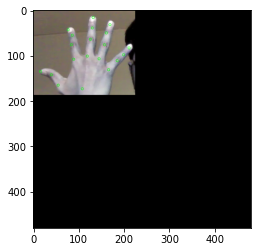

In [4]:
# Choose one dataset:
dataset_number = 2 # 1: Entire frames, 2: Cropped hands.

if dataset_number == 1:
    X = np.load('data/480x640_X.npy')
    Y = np.load('data/480x640_Y.npy')
elif dataset_number == 2:
    X = np.load('data/480x480_X.npy', allow_pickle=True)
    Y = np.load('data/480x480_Y.npy', allow_pickle=True)
    
print(X.shape)
print(Y.shape)
# Show random frame
showRandomFrame(X, Y)

### Resize frames and landamrks by factor of 5. 
This because computer cannot alcatate enough memory for frames of original shape into one numpy array.
Codes does:
- Resize frames and landmarks
- Convert into numpy array of dtype np.float32.
- Saves data in to folder 'data'

In [53]:
# Resize frames and landmarks by factor 5
frames_resized = []

for frame in tqdm(X):
    frames_resized.append(cv2.resize(frame, (96, 96), interpolation = cv2.INTER_AREA) )
frames_resized = np.array(frames_resized).astype(np.float32)

landmarks_resized = Y.astype(np.float32)/5.0 # Scaled landmarks by factor 5.

np.save('data/96x96_X.npy', frames_resized)
np.save('data/96x96_Y.npy', landmarks_resized)
print("saved.")

print(frames_resized.shape)
print(landmarks_resized.shape)

100%|██████████████████████████████████████████████████████████████████████████| 11200/11200 [00:07<00:00, 1580.20it/s]


saved.
(11200, 96, 96, 3)
(11200, 80)


### Split into train test datasets


In [56]:
# Split into train and test sets
frames_resized = np.load('data/96x96_X.npy')
landmarks_resized = np.load('data/96x96_Y.npy')

Xtrain, Xtest, Ytrain, Ytest = train_test_split(frames_resized, landmarks_resized, test_size=0.20, random_state=42)
np.save('data/96x96_Xtrain.npy', Xtrain)
np.save('data/96x96_Xtest.npy', Xtest)
np.save('data/96x96_Ytrain.npy', Ytrain)
np.save('data/96x96_Ytest.npy', Ytest)

print(f"Xtrain: {Xtrain.shape}")
print(f"Xtest: {Xtest.shape}")
print(f"Ytrain: {Ytrain.shape}")
print(f"Ytest: {Ytest.shape}")


Xtrain: (8960, 96, 96, 3)
Xtest: (2240, 96, 96, 3)
Ytrain: (8960, 80)
Ytest: (2240, 80)


# Train model
There are two available datasets. Run one on them.

In [5]:
# Load dataset 2: Cropped hands frame.
LOAD_DATASET_NUM = 2

if LOAD_DATASET_NUM == 1:
    pass
elif LOAD_DATASET_NUM == 2:
    Xtrain = np.load('data/96x96_Xtrain.npy')/255.0
    Ytrain = (np.load('data/96x96_Ytrain.npy') - 48) / 48
    Xtest  = np.load('data/96x96_Xtest.npy')/255.0
    Ytest  = (np.load('data/96x96_Ytest.npy') - 48) / 48
    
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

(8960, 96, 96, 3)
(8960, 80)
(2240, 96, 96, 3)
(2240, 80)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


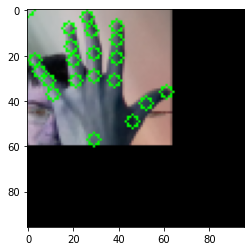

In [15]:
# Showing random frame
showRandomFrame(Xtrain, Ytrain*48 + 48)

Xtrain: (8960, 96, 96)
Xtest: (2240, 96, 96)


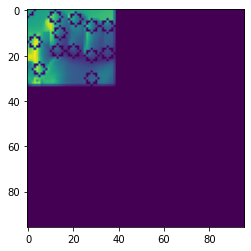

In [6]:
# If wanted. Convert to gray color

Xtrain_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in Xtrain], dtype=np.float32)
Xtest_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in Xtest], dtype=np.float32)

print(f"Xtrain: {Xtrain_gray.shape}")
print(f"Xtest: {Xtest_gray.shape}")

showRandomFrame(Xtrain_gray, Ytrain*48 + 48)

### The model

In [7]:
# Main model
def CNN_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(96, 96, 1))) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(80))
    
    return model


In [13]:
# Prepare model
epochs = 100
batch_size = 64
checkpoint_file = 'checkpoint.hdf5'
model_file_name = 'model.h5'

# Load saved model or create a new one
if checkpoint_file in os.listdir('models'):
    model = load_model(os.path.join('models', checkpoint_file))
elif model_file_name in os.listdir('models'):
    model = load_model(os.path.join('models', model_file_name))
else:
    model = CNN_model()
    
hist = History()
checkpointer = ModelCheckpoint(
    filepath=checkpoint_file, verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['accuracy'])
model_fit = model.fit(np.expand_dims(Xtrain_gray, axis=-1), Ytrain, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)
# model_fit = model.fit(Xtrain, Ytrain, validation_data=(
#     Xtest, Ytest), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save(os.path.join('models', model_file_name))

Epoch 1/100
 14/112 [==>...........................] - ETA: 21s - loss: 0.0015 - accuracy: 0.8337

KeyboardInterrupt: 

# Test model

In [12]:
model = load_model('models/model.h5')
print("Loaded")

Loaded


In [9]:

model.evaluate(np.expand_dims(Xtest_gray, axis=-1), Ytest)

70/70 [==============================] - 3s 38ms/step - loss: 3.0875e-04 - accuracy: 0.9388


[0.0003087542427238077, 0.9388392567634583]

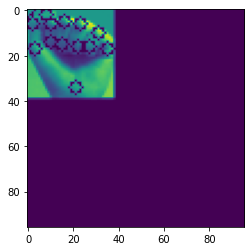

In [40]:
randint = random.randint(0, len(Xtest))
randFrame = Xtest_gray[randint]
    
# Input layer shape (96, 96 ,3)
prediction = model.predict(randFrame.reshape(1,96,96,1))

displayFrame(randFrame, prediction*48+48)

In [169]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 96, 'height': 96 }
                       })

camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 96, 'height': 96}})

In [170]:
recorder = ImageRecorder(stream=camera)
recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

In [171]:
camera.close()
snapshot = recorder.image.value
snapshot = np.frombuffer(snapshot, dtype=np.uint8)
snapshot = cv2.imdecode(snapshot, cv2.IMREAD_COLOR)
snapshot_bw = cv2.cvtColor(snapshot, cv2.COLOR_BGR2GRAY)
snapshot_bw = snapshot.reshape(96,96,1)
snapshot_bw = snapshot.astype(np.float32)/255.0
snapshot_bw.shape

ValueError: cannot reshape array of size 27648 into shape (96,96,1)

In [192]:
model = load_model('models/model.h5')

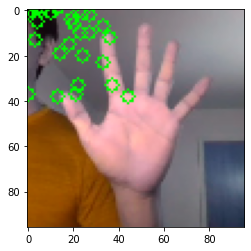

In [194]:
# Input layer shape (96, 96 ,3)
prediction = model.predict(snapshot_bw.reshape(1,96,96,1))

displayFrame(snapshot, prediction*48+48)

In [188]:
# Code below shows random frame with landmarks
i_rand = np.random.randint(0, len(Xtrain))
rand_frame = Xtrain[i_rand].reshape(1,96,96,3)
displayFrame(rand_frame, model.predict(rand_frame)*96+96)

ValueError: in user code:

    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Rodas\anaconda3\envs\IIS\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 1 but received input with shape [None, 96, 96, 3]
